# **Models and their Evaluation**

In this section various models will be created and evaluated.

**Install RD-Kit.**

RD-Kit is an open-source Python package for data scientists to work with chemistry data.

In [ ]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 11.5 MB/s eta 0:00:00


**Install the other required packages.**

In [ ]:
! pip install py3Dmol

In [ ]:
! pip install mol2vec gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.5 MB/s eta 0:00:00


In [ ]:
! pip install xgboost
! pip install lightgbm

**Import necessary libraries and modules.**

In [ ]:
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
import warnings
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
import py3Dmol
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
from rdkit.Chem import Crippen
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles
from mol2vec.features import mol2alt_sentence, MolSentence
import gensim
import pickle
from mol2vec.features import mol2sentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from gensim.models import Word2Vec
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import lightgbm as lgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.pipeline import Pipeline

In [ ]:
# Loading the DataFrame from a CSV file

df = pd.read_csv('/content/drive/My Drive/df.csv')

*Determine X and y for the models.*

In [ ]:
target_columns = ['SR-HSE', 'NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR',
                  'SR-MMP', 'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']
feature_columns = df.columns.difference(['Formula', 'FW', 'DSSTox_CID', 'ID', 'ROMol', 'SMILES', 'mol2vec', 'sentence'] + target_columns)

In [ ]:
feature_columns

Index(['LogP', 'MW', 'PSA', 'mol2vec_0', 'mol2vec_1', 'mol2vec_10',
       'mol2vec_11', 'mol2vec_12', 'mol2vec_13', 'mol2vec_14',
       ...
       'mol2vec_95', 'mol2vec_96', 'mol2vec_97', 'mol2vec_98', 'mol2vec_99',
       'num_h_acceptors', 'num_h_donors', 'num_heteroatoms',
       'num_of_heavy_atoms', 'num_rot_bonds'],
      dtype='object', length=108)

*HistGradientBoostingClassifier*

In [ ]:
# Directory where models will be saved
save_dir = "/content/drive/My Drive/saved_models/model_1"
os.makedirs(save_dir, exist_ok=True)

#Storing metrics for each model
metrics_1 = {}

#Calculating model for each assay separately
models_1 = {}
for col in target_columns:
    y = df[col].dropna()
    y = y.astype(int)
    X = df.loc[y.index, feature_columns]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_1 = HistGradientBoostingClassifier(random_state=42)
    model_1.fit(X_train, y_train)
    y_pred = model_1.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_1 = os.path.join(save_dir, f"model_1_{col}.pkl")
    joblib.dump(model_1, model_path_1)  # Saving the model using joblib
    models_1[col] = model_1

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_1[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1549
           1       0.52      0.14      0.22        81

    accuracy                           0.95      1630
   macro avg       0.74      0.56      0.60      1630
weighted avg       0.93      0.95      0.94      1630

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1792
           1       0.36      0.10      0.16        80

    accuracy                           0.95      1872
   macro avg       0.66      0.55      0.57      1872
weighted avg       0.94      0.95      0.94      1872

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1215
           1       0.53      0.14      0.22       218

    accuracy                           0.85      1433
   macro avg       0.69      0.56      0.57      1433
weighted avg      

*HistGradientBoostingClassifier with weights*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_2"
os.makedirs(save_dir, exist_ok=True)

metrics_2 = {}

models_2 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)

    # Selecting corresponding feature rows and drop NaN values in X
    X = df.loc[y.index, feature_columns].dropna()

    # Ensuring y matches the indices of X after dropping NaN values
    y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calculating class weights
    class_weights = len(y_train) / (2 * np.bincount(y_train))
    class_weights = dict(zip([0, 1], class_weights))

    model_2 = HistGradientBoostingClassifier(random_state=42, class_weight=class_weights)
    model_2.fit(X_train, y_train)
    y_pred = model_2.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_2 = os.path.join(save_dir, f"model_2_{col}.pkl")
    joblib.dump(model_2, model_path_2)
    models_2[col] = model_2

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_2[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1544
           1       0.32      0.21      0.26        85

    accuracy                           0.94      1629
   macro avg       0.64      0.59      0.61      1629
weighted avg       0.92      0.94      0.93      1629

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1803
           1       0.34      0.31      0.33        68

    accuracy                           0.95      1871
   macro avg       0.66      0.64      0.65      1871
weighted avg       0.95      0.95      0.95      1871

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      1214
           1       0.40      0.40      0.40       218

    accuracy                           0.82      1432
   macro avg       0.64      0.65      0.65      1432
weighted avg      

*HistGradientBoostingClassifier using SMOTE*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_3"
os.makedirs(save_dir, exist_ok=True)

metrics_3 = {}

models_3 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()
    y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Applying SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model_3 = HistGradientBoostingClassifier(random_state=42)
    model_3.fit(X_train_res, y_train_res)
    y_pred = model_3.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_3 = os.path.join(save_dir, f"model_3_{col}.pkl")
    joblib.dump(model_3, model_path_3)
    models_3[col] = model_3

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_3[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1544
           1       0.33      0.16      0.22        85

    accuracy                           0.94      1629
   macro avg       0.64      0.57      0.59      1629
weighted avg       0.92      0.94      0.93      1629

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1803
           1       0.38      0.38      0.38        68

    accuracy                           0.96      1871
   macro avg       0.68      0.68      0.68      1871
weighted avg       0.96      0.96      0.96      1871

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1214
           1       0.46      0.31      0.37       218

    accuracy                           0.84      1432
   macro avg       0.67      0.62      0.64      1432
weighted avg      

*Random Forest*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_4"
os.makedirs(save_dir, exist_ok=True)

metrics_4 = {}

models_4 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()

    y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_4 = RandomForestClassifier(random_state=42, class_weight='balanced')
    model_4.fit(X_train, y_train)
    y_pred = model_4.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_4 = os.path.join(save_dir, f"model_4_{col}.pkl")
    joblib.dump(model_4, model_path_4)
    models_4[col] = model_4

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_4[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1544
           1       0.62      0.06      0.11        85

    accuracy                           0.95      1629
   macro avg       0.79      0.53      0.54      1629
weighted avg       0.93      0.95      0.93      1629

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1803
           1       0.45      0.07      0.13        68

    accuracy                           0.96      1871
   macro avg       0.71      0.54      0.55      1871
weighted avg       0.95      0.96      0.95      1871

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      1214
           1       0.44      0.06      0.11       218

    accuracy                           0.84      1432
   macro avg       0.65      0.52      0.51      1432
weighted avg      

*AdaBoost*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_5"
os.makedirs(save_dir, exist_ok=True)

metrics_5 = {}

models_5 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()

    y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

     # Applying SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model_5 = AdaBoostClassifier(random_state=42)
    model_5.fit(X_train, y_train)
    y_pred = model_5.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_5 = os.path.join(save_dir, f"model_5_{col}.pkl")
    joblib.dump(model_5, model_path_5)
    models_5[col] = model_5

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_5[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1544
           1       0.55      0.07      0.12        85

    accuracy                           0.95      1629
   macro avg       0.75      0.53      0.55      1629
weighted avg       0.93      0.95      0.93      1629

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1803
           1       0.39      0.10      0.16        68

    accuracy                           0.96      1871
   macro avg       0.68      0.55      0.57      1871
weighted avg       0.95      0.96      0.95      1871

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1214
           1       0.51      0.15      0.23       218

    accuracy                           0.85      1432
   macro avg       0.69      0.56      0.57      1432
weighted avg      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

Report for SR-p53:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1618
           1       0.54      0.07      0.12       107

    accuracy                           0.94      1725
   macro avg       0.74      0.53      0.54      1725
weighted avg       0.92      0.94      0.92      1725

Report for SR-ATAD5:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1754
           1       0.00      0.00      0.00        63

    accuracy                           0.96      1817
   macro avg       0.48      0.50      0.49      1817
weighted avg       0.93      0.96      0.95      1817

Report for NR-AR-LBD:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1652
           1       0.55      0.17      0.26        66

    accuracy                           0.96      1718
   macro avg       0.76      0.58      0.62      1718
weighted avg

*SVM*

In [ ]:
#save_dir = "/content/drive/My Drive/saved_models/model_6"
#os.makedirs(save_dir, exist_ok=True)

metrics_6 = {}

models_6 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()

    y = y.loc[X.index]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Creating SVC model
    model_6 = SVC(random_state=42, class_weight='balanced')

    model_6.fit(X_train, y_train)
    y_pred = model_6.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    #model_path_6 = os.path.join(save_dir, f"model_6_{col}.pkl")
    #joblib.dump(model_6, model_path_6)  # Saving the model using joblib
    models_6[col] = model_6

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_6[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81      1544
           1       0.10      0.62      0.17        85

    accuracy                           0.69      1629
   macro avg       0.54      0.66      0.49      1629
weighted avg       0.93      0.69      0.78      1629

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.98      0.68      0.81      1803
           1       0.08      0.72      0.14        68

    accuracy                           0.69      1871
   macro avg       0.53      0.70      0.48      1871
weighted avg       0.95      0.69      0.78      1871

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.93      0.57      0.71      1214
           1       0.24      0.77      0.37       218

    accuracy                           0.60      1432
   macro avg       0.59      0.67      0.54      1432
weighted avg      

*XGBoost*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_7"
os.makedirs(save_dir, exist_ok=True)

metrics_7 = {}

models_7 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()
    y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_7 = xgb.XGBClassifier(scale_pos_weight=1) # Adjusting scale_pos_weight for class imbalance
    model_7.fit(X_train, y_train)
    y_pred = model_7.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_7 = os.path.join(save_dir, f"model_7_{col}.json")
    model_7.save_model(model_path_7)
    models_7[col] = model_7

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_7[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1544
           1       0.50      0.09      0.16        85

    accuracy                           0.95      1629
   macro avg       0.73      0.54      0.57      1629
weighted avg       0.93      0.95      0.93      1629

Report for NR-AR:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1803
           1       0.42      0.15      0.22        68

    accuracy                           0.96      1871
   macro avg       0.69      0.57      0.60      1871
weighted avg       0.95      0.96      0.95      1871

Report for SR-ARE:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1214
           1       0.44      0.15      0.22       218

    accuracy                           0.84      1432
   macro avg       0.65      0.56      0.57      1432
weighted avg      

*LightGBM*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_8"
os.makedirs(save_dir, exist_ok=True)

metrics_8 = {}

models_8 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()
    y = y.loc[X.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model_8 = lgb.LGBMClassifier(is_unbalance=True)  # Using is_unbalance=True for class imbalance
    model_8.fit(X_train, y_train)
    y_pred = model_8.predict(X_test)

    print(f"Report for {col}:")
    print(classification_report(y_test, y_pred))

    model_path_8 = os.path.join(save_dir, f"model_8_{col}.txt")
    model_8.booster_.save_model(model_path_8)
    models_8[col] = model_8

    report = classification_report(y_test, y_pred, output_dict=True)
    metrics_8[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test, y_pred)
    }

[LightGBM] [Info] Number of positive: 343, number of negative: 6170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26424
[LightGBM] [Info] Number of data points in the train set: 6513, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.052664 -> initscore=-2.889724
[LightGBM] [Info] Start training from score -2.889724
Report for SR-HSE:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1544
           1       0.29      0.20      0.24        85

    accuracy                           0.93      1629
   macro avg       0.62      0.59      0.60      1629
weighted avg       0.92      0.93      0.93      1629

[LightGBM] [Info] Number of positive: 312, number of negative: 7170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054743

*Neural Network (FNN)*

In [ ]:
save_dir = "/content/drive/My Drive/saved_models/model_9"
os.makedirs(save_dir, exist_ok=True)

metrics_9 = {}

models_9 = {}
for col in target_columns:
    y = df[col].dropna().astype(int)
    X = df.loc[y.index, feature_columns].dropna()
    y = y.loc[X.index]

    # Converting y to categorical
    y = to_categorical(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Applying SMOTE
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train.argmax(axis=1))
    y_train_res = to_categorical(y_train_res)

    # Converting to float32
    X_train_res = X_train_res.astype(np.float32)
    X_test = X_test.astype(np.float32)
    y_train_res = y_train_res.astype(np.float32)
    y_test = y_test.astype(np.float32)

    # Setting a fixed learning rate
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)

    # Building the FNN model
    model_9 = Sequential([
        Dense(256, input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(y_train_res.shape[1], activation='softmax')
    ])

    model_9.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Setting up the ReduceLROnPlateau callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.001,
        patience=10,
        min_lr=0.00001)

    model_9.fit(X_train_res, y_train_res, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[reduce_lr])

    y_pred = model_9.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    print(f"Report for {col}:")
    print(classification_report(y_test_classes, y_pred_classes))

    models_9[col] = model_9

    report = classification_report(y_test_classes, y_pred_classes, output_dict=True)
    metrics_9[col] = {
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1-score_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1-score_1': report['1']['f1-score'],
        'accuracy': accuracy_score(y_test_classes, y_pred_classes)
    }

    #Saving the model
    model_path_9 = os.path.join(save_dir, f"model_9_{col}.h5")
    model_9.save(model_path_9)
    models_9[col] = model_9

Epoch 1/15
386/386 [==============================] - 5s 8ms/step - loss: 0.6543 - accuracy: 0.6805 - val_loss: 0.5037 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 2/15
386/386 [==============================] - 4s 11ms/step - loss: 0.5031 - accuracy: 0.7592 - val_loss: 0.5218 - val_accuracy: 0.7066 - lr: 0.0010
Epoch 3/15
386/386 [==============================] - 4s 10ms/step - loss: 0.4578 - accuracy: 0.7867 - val_loss: 0.4141 - val_accuracy: 0.7864 - lr: 0.0010
Epoch 4/15
386/386 [==============================] - 4s 11ms/step - loss: 0.4251 - accuracy: 0.8030 - val_loss: 0.4896 - val_accuracy: 0.7416 - lr: 0.0010
Epoch 5/15
386/386 [==============================] - 5s 13ms/step - loss: 0.3969 - accuracy: 0.8215 - val_loss: 0.4182 - val_accuracy: 0.7980 - lr: 0.0010
Epoch 6/15
386/386 [==============================] - 6s 14ms/step - loss: 0.3792 - accuracy: 0.8298 - val_loss: 0.4271 - val_accuracy: 0.7827 - lr: 0.0010
Epoch 7/15
386/386 [==============================] - 3s 7ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
449/449 [==============================] - 6s 10ms/step - loss: 0.5639 - accuracy: 0.7339 - val_loss: 0.4985 - val_accuracy: 0.7151 - lr: 0.0010
Epoch 2/15
449/449 [==============================] - 3s 7ms/step - loss: 0.4176 - accuracy: 0.8112 - val_loss: 0.4275 - val_accuracy: 0.7873 - lr: 0.0010
Epoch 3/15
449/449 [==============================] - 2s 6ms/step - loss: 0.3701 - accuracy: 0.8389 - val_loss: 0.3616 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 4/15
449/449 [==============================] - 3s 6ms/step - loss: 0.3434 - accuracy: 0.8544 - val_loss: 0.4114 - val_accuracy: 0.8188 - lr: 0.0010
Epoch 5/15
449/449 [==============================] - 3s 6ms/step - loss: 0.3251 - accuracy: 0.8628 - val_loss: 0.3822 - val_accuracy: 0.8279 - lr: 0.0010
Epoch 6/15
449/449 [==============================] - 4s 9ms/step - loss: 0.3051 - accuracy: 0.8734 - val_loss: 0.3399 - val_accuracy: 0.8514 - lr: 0.0010
Epoch 7/15
449/449 [==============================] - 3s 7ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
304/304 [==============================] - 5s 10ms/step - loss: 0.7274 - accuracy: 0.6297 - val_loss: 0.5786 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 2/15
304/304 [==============================] - 2s 7ms/step - loss: 0.5978 - accuracy: 0.6932 - val_loss: 0.5614 - val_accuracy: 0.6851 - lr: 0.0010
Epoch 3/15
304/304 [==============================] - 2s 6ms/step - loss: 0.5660 - accuracy: 0.7144 - val_loss: 0.5734 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 4/15
304/304 [==============================] - 2s 6ms/step - loss: 0.5556 - accuracy: 0.7219 - val_loss: 0.5592 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 5/15
304/304 [==============================] - 2s 6ms/step - loss: 0.5425 - accuracy: 0.7339 - val_loss: 0.5500 - val_accuracy: 0.7004 - lr: 0.0010
Epoch 6/15
304/304 [==============================] - 2s 6ms/step - loss: 0.5304 - accuracy: 0.7415 - val_loss: 0.5880 - val_accuracy: 0.6767 - lr: 0.0010
Epoch 7/15
304/304 [==============================] - 2s 6ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
344/344 [==============================] - 5s 8ms/step - loss: 0.5691 - accuracy: 0.7352 - val_loss: 0.5602 - val_accuracy: 0.6946 - lr: 0.0010
Epoch 2/15
344/344 [==============================] - 2s 6ms/step - loss: 0.4475 - accuracy: 0.7985 - val_loss: 0.5151 - val_accuracy: 0.7175 - lr: 0.0010
Epoch 3/15
344/344 [==============================] - 2s 6ms/step - loss: 0.3977 - accuracy: 0.8275 - val_loss: 0.5030 - val_accuracy: 0.7417 - lr: 0.0010
Epoch 4/15
344/344 [==============================] - 2s 6ms/step - loss: 0.3712 - accuracy: 0.8400 - val_loss: 0.4945 - val_accuracy: 0.7465 - lr: 0.0010
Epoch 5/15
344/344 [==============================] - 2s 6ms/step - loss: 0.3382 - accuracy: 0.8563 - val_loss: 0.4572 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 6/15
344/344 [==============================] - 3s 8ms/step - loss: 0.3224 - accuracy: 0.8653 - val_loss: 0.4312 - val_accuracy: 0.7922 - lr: 0.0010
Epoch 7/15
344/344 [==============================] - 3s 9ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
416/416 [==============================] - 4s 6ms/step - loss: 0.5949 - accuracy: 0.7177 - val_loss: 0.5924 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 2s 5ms/step - loss: 0.4465 - accuracy: 0.7910 - val_loss: 0.5312 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 3s 7ms/step - loss: 0.4048 - accuracy: 0.8210 - val_loss: 0.4963 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 4s 9ms/step - loss: 0.3789 - accuracy: 0.8324 - val_loss: 0.4789 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 2s 5ms/step - loss: 0.3625 - accuracy: 0.8423 - val_loss: 0.4494 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - 2s 5ms/step - loss: 0.3443 - accuracy: 0.8515 - val_loss: 0.4275 - val_accuracy: 0.8159 - lr: 0.0010
Epoch 7/15
416/416 [==============================] - 2s 5ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
361/361 [==============================] - 5s 6ms/step - loss: 0.7390 - accuracy: 0.6284 - val_loss: 0.6993 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 2/15
361/361 [==============================] - 2s 6ms/step - loss: 0.5498 - accuracy: 0.7269 - val_loss: 0.6709 - val_accuracy: 0.5974 - lr: 0.0010
Epoch 3/15
361/361 [==============================] - 2s 6ms/step - loss: 0.5030 - accuracy: 0.7592 - val_loss: 0.7065 - val_accuracy: 0.6005 - lr: 0.0010
Epoch 4/15
361/361 [==============================] - 3s 8ms/step - loss: 0.4807 - accuracy: 0.7699 - val_loss: 0.6087 - val_accuracy: 0.6532 - lr: 0.0010
Epoch 5/15
361/361 [==============================] - 3s 10ms/step - loss: 0.4634 - accuracy: 0.7887 - val_loss: 0.5470 - val_accuracy: 0.6991 - lr: 0.0010
Epoch 6/15
361/361 [==============================] - 2s 6ms/step - loss: 0.4545 - accuracy: 0.7933 - val_loss: 0.5694 - val_accuracy: 0.6979 - lr: 0.0010
Epoch 7/15
361/361 [==============================] - 2s 6ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
309/309 [==============================] - 5s 9ms/step - loss: 0.6287 - accuracy: 0.7026 - val_loss: 0.6886 - val_accuracy: 0.6418 - lr: 0.0010
Epoch 2/15
309/309 [==============================] - 3s 10ms/step - loss: 0.4723 - accuracy: 0.7805 - val_loss: 0.5703 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 3/15
309/309 [==============================] - 2s 6ms/step - loss: 0.4450 - accuracy: 0.7940 - val_loss: 0.5252 - val_accuracy: 0.7239 - lr: 0.0010
Epoch 4/15
309/309 [==============================] - 2s 6ms/step - loss: 0.4278 - accuracy: 0.8067 - val_loss: 0.5122 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 5/15
309/309 [==============================] - 2s 6ms/step - loss: 0.4261 - accuracy: 0.8126 - val_loss: 0.5504 - val_accuracy: 0.7307 - lr: 0.0010
Epoch 6/15
309/309 [==============================] - 2s 6ms/step - loss: 0.4083 - accuracy: 0.8192 - val_loss: 0.5602 - val_accuracy: 0.7211 - lr: 0.0010
Epoch 7/15
309/309 [==============================] - 2s 6ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
338/338 [==============================] - 6s 10ms/step - loss: 0.7646 - accuracy: 0.6053 - val_loss: 0.6428 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 2/15
338/338 [==============================] - 2s 6ms/step - loss: 0.6072 - accuracy: 0.6796 - val_loss: 0.6526 - val_accuracy: 0.6053 - lr: 0.0010
Epoch 3/15
338/338 [==============================] - 2s 5ms/step - loss: 0.5649 - accuracy: 0.7100 - val_loss: 0.6309 - val_accuracy: 0.6515 - lr: 0.0010
Epoch 4/15
338/338 [==============================] - 2s 6ms/step - loss: 0.5397 - accuracy: 0.7325 - val_loss: 0.5765 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 5/15
338/338 [==============================] - 2s 6ms/step - loss: 0.5272 - accuracy: 0.7366 - val_loss: 0.5826 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 6/15
338/338 [==============================] - 2s 6ms/step - loss: 0.5172 - accuracy: 0.7441 - val_loss: 0.5851 - val_accuracy: 0.6996 - lr: 0.0010
Epoch 7/15
338/338 [==============================] - 3s 8ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
398/398 [==============================] - 4s 6ms/step - loss: 0.5710 - accuracy: 0.7301 - val_loss: 0.6135 - val_accuracy: 0.6532 - lr: 0.0010
Epoch 2/15
398/398 [==============================] - 2s 6ms/step - loss: 0.4206 - accuracy: 0.8081 - val_loss: 0.4713 - val_accuracy: 0.7535 - lr: 0.0010
Epoch 3/15
398/398 [==============================] - 2s 6ms/step - loss: 0.3655 - accuracy: 0.8446 - val_loss: 0.4270 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 4/15
398/398 [==============================] - 3s 8ms/step - loss: 0.3158 - accuracy: 0.8677 - val_loss: 0.4893 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 5/15
398/398 [==============================] - 4s 9ms/step - loss: 0.2844 - accuracy: 0.8848 - val_loss: 0.3214 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 6/15
398/398 [==============================] - 2s 6ms/step - loss: 0.2572 - accuracy: 0.8947 - val_loss: 0.3070 - val_accuracy: 0.8820 - lr: 0.0010
Epoch 7/15
398/398 [==============================] - 2s 6ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
405/405 [==============================] - 4s 6ms/step - loss: 0.6087 - accuracy: 0.7038 - val_loss: 0.6145 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 2/15
405/405 [==============================] - 2s 5ms/step - loss: 0.4873 - accuracy: 0.7726 - val_loss: 0.5629 - val_accuracy: 0.6603 - lr: 0.0010
Epoch 3/15
405/405 [==============================] - 2s 5ms/step - loss: 0.4433 - accuracy: 0.7959 - val_loss: 0.6015 - val_accuracy: 0.6730 - lr: 0.0010
Epoch 4/15
405/405 [==============================] - 2s 6ms/step - loss: 0.4244 - accuracy: 0.8075 - val_loss: 0.5272 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 5/15
405/405 [==============================] - 4s 9ms/step - loss: 0.4007 - accuracy: 0.8251 - val_loss: 0.5193 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 6/15
405/405 [==============================] - 3s 8ms/step - loss: 0.3790 - accuracy: 0.8314 - val_loss: 0.5633 - val_accuracy: 0.7148 - lr: 0.0010
Epoch 7/15
405/405 [==============================] - 2s 5ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
437/437 [==============================] - 6s 9ms/step - loss: 0.6325 - accuracy: 0.6937 - val_loss: 0.5909 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 2/15
437/437 [==============================] - 2s 5ms/step - loss: 0.4681 - accuracy: 0.7808 - val_loss: 0.5079 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 3/15
437/437 [==============================] - 2s 6ms/step - loss: 0.4067 - accuracy: 0.8143 - val_loss: 0.4411 - val_accuracy: 0.7744 - lr: 0.0010
Epoch 4/15
437/437 [==============================] - 2s 6ms/step - loss: 0.3796 - accuracy: 0.8299 - val_loss: 0.4491 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 5/15
437/437 [==============================] - 3s 6ms/step - loss: 0.3495 - accuracy: 0.8459 - val_loss: 0.4378 - val_accuracy: 0.7804 - lr: 0.0010
Epoch 6/15
437/437 [==============================] - 4s 9ms/step - loss: 0.3324 - accuracy: 0.8536 - val_loss: 0.3726 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 7/15
437/437 [==============================] - 3s 6ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
415/415 [==============================] - 6s 10ms/step - loss: 0.5337 - accuracy: 0.7551 - val_loss: 0.4359 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 2/15
415/415 [==============================] - 2s 5ms/step - loss: 0.3539 - accuracy: 0.8471 - val_loss: 0.3820 - val_accuracy: 0.8190 - lr: 0.0010
Epoch 3/15
415/415 [==============================] - 2s 5ms/step - loss: 0.3053 - accuracy: 0.8718 - val_loss: 0.3693 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 4/15
415/415 [==============================] - 2s 6ms/step - loss: 0.2681 - accuracy: 0.8934 - val_loss: 0.3839 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 5/15
415/415 [==============================] - 2s 5ms/step - loss: 0.2407 - accuracy: 0.9053 - val_loss: 0.3007 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 6/15
415/415 [==============================] - 3s 7ms/step - loss: 0.2336 - accuracy: 0.9085 - val_loss: 0.2746 - val_accuracy: 0.8818 - lr: 0.0010
Epoch 7/15
415/415 [==============================] - 4s 9ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Compare models**

*Combined metrics from all models.*

In [ ]:
metrics_list = [metrics_1, metrics_2, metrics_3, metrics_4, metrics_5, metrics_6, metrics_7, metrics_8, metrics_9]
df_list = []

for i, metrics in enumerate(metrics_list, start=1):
    df_m = pd.DataFrame(metrics).T
    df_list.append(df_m)
    globals()[f'df_metrics_{i}'] = df_m

for i, df_m in enumerate(df_list, start=1):
    print(f"DataFrame df_metrics_{i}:")
    print(df_m.head())

DataFrame df_metrics_1:
              precision_0  recall_0  f1-score_0  precision_1  recall_1  \
SR-HSE           0.956495  0.993544    0.974668     0.523810  0.135802   
NR-AR            0.961081  0.992188    0.976387     0.363636  0.100000   
SR-ARE           0.863901  0.976955    0.916956     0.525424  0.142202   
NR-Aromatase     0.955276  0.994182    0.974341     0.428571  0.085714   
NR-ER-LBD        0.957101  0.995178    0.975768     0.680000  0.186813   

              f1-score_1  accuracy  
SR-HSE          0.215686  0.950920  
NR-AR           0.156863  0.954060  
SR-ARE          0.223827  0.849965  
NR-Aromatase    0.142857  0.950173  
NR-ER-LBD       0.293103  0.953143  
DataFrame df_metrics_2:
              precision_0  recall_0  f1-score_0  precision_1  recall_1  \
SR-HSE           0.957406  0.975389    0.966314     0.321429  0.211765   
NR-AR            0.974033  0.977815    0.975920     0.344262  0.308824   
SR-ARE           0.892562  0.889621    0.891089     0.396396  0

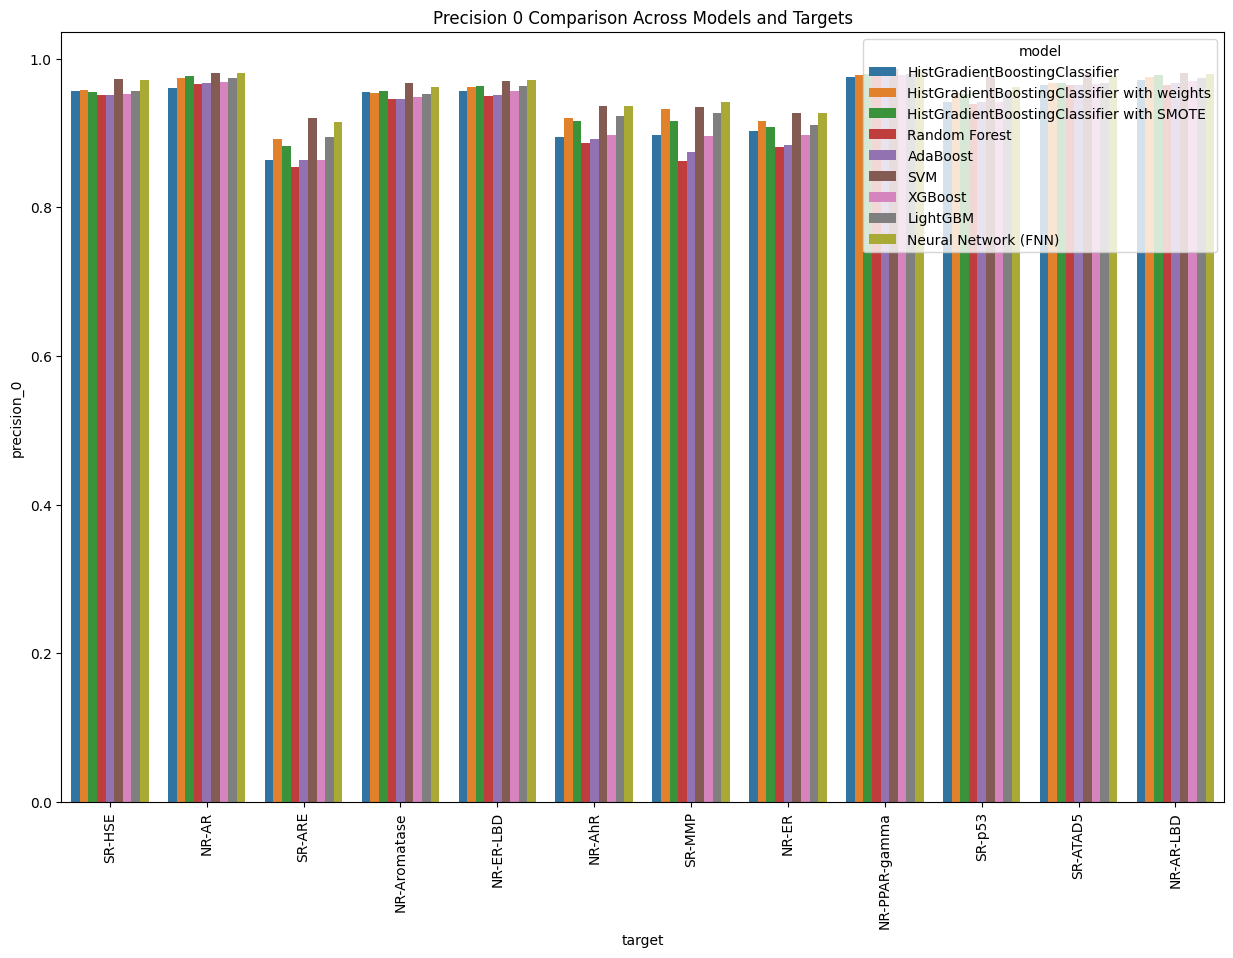

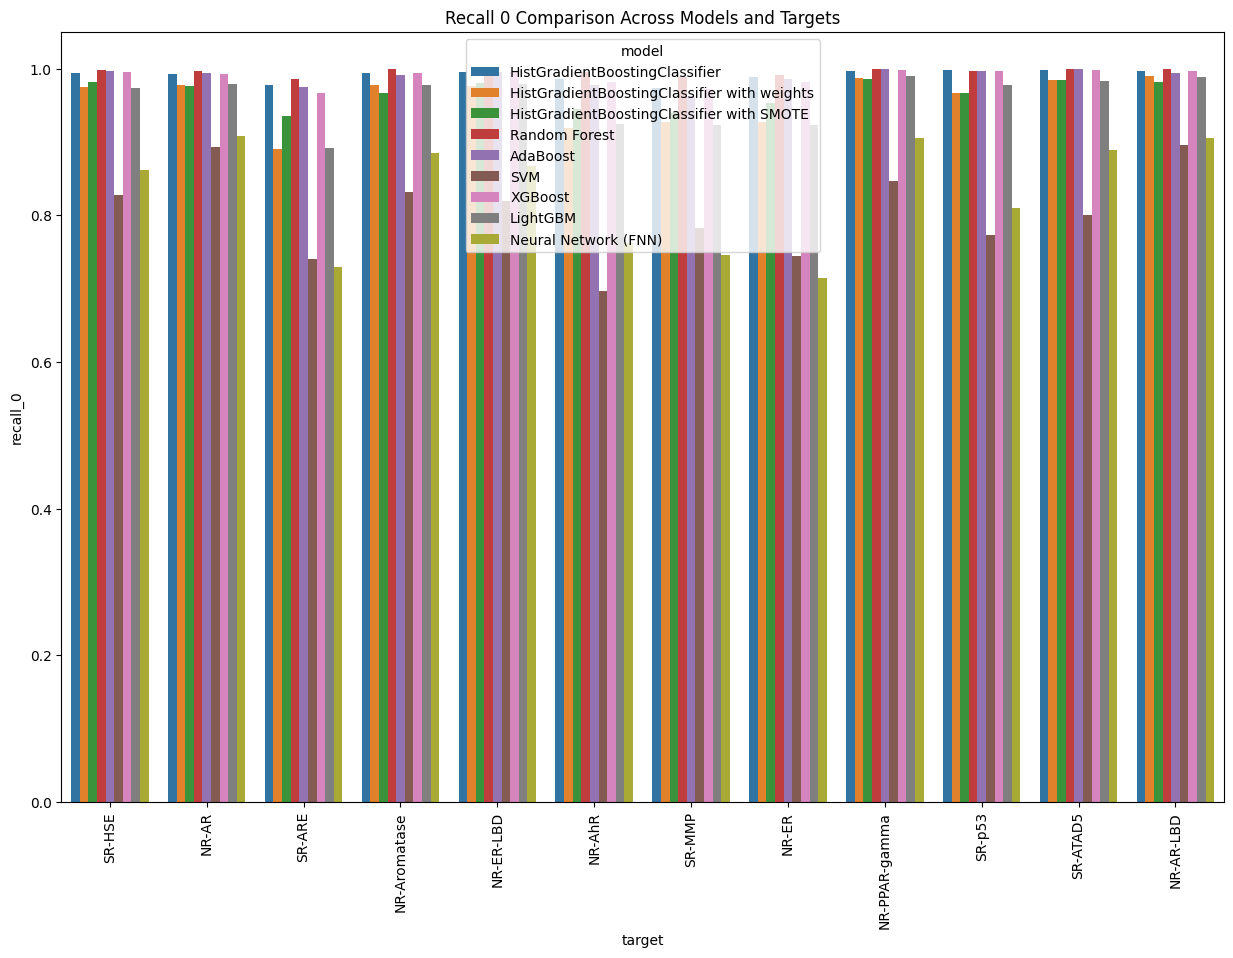

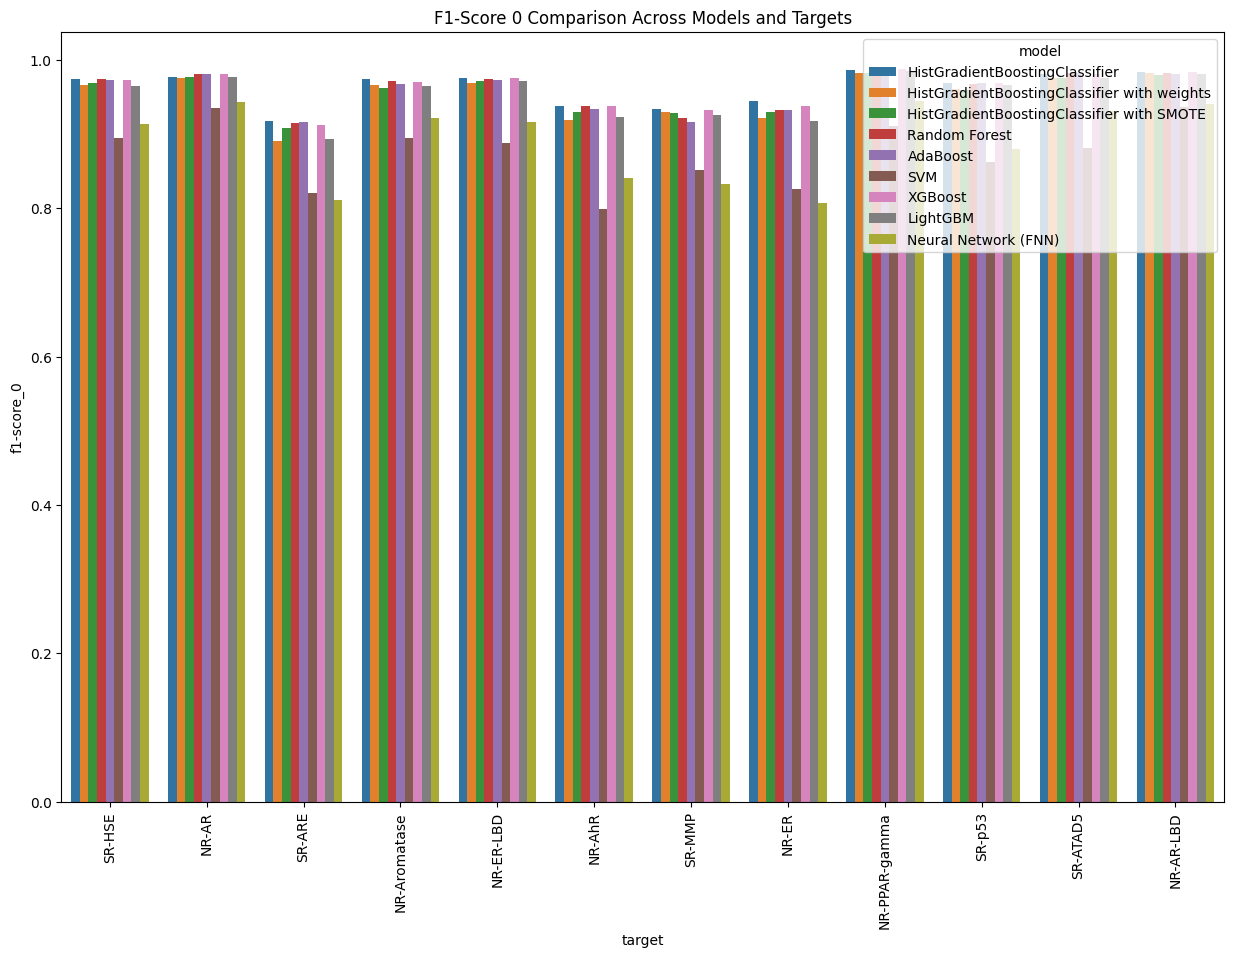

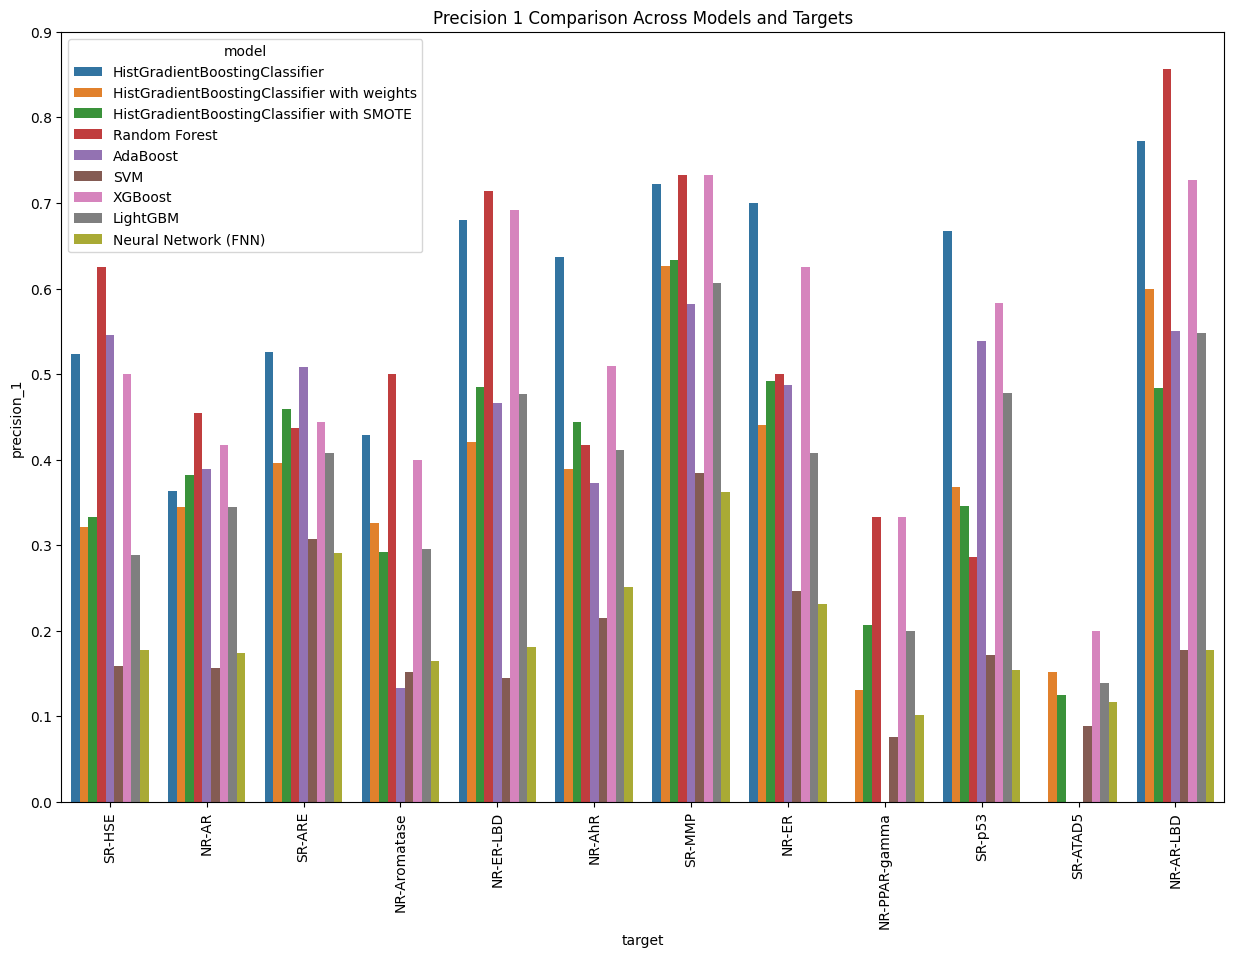

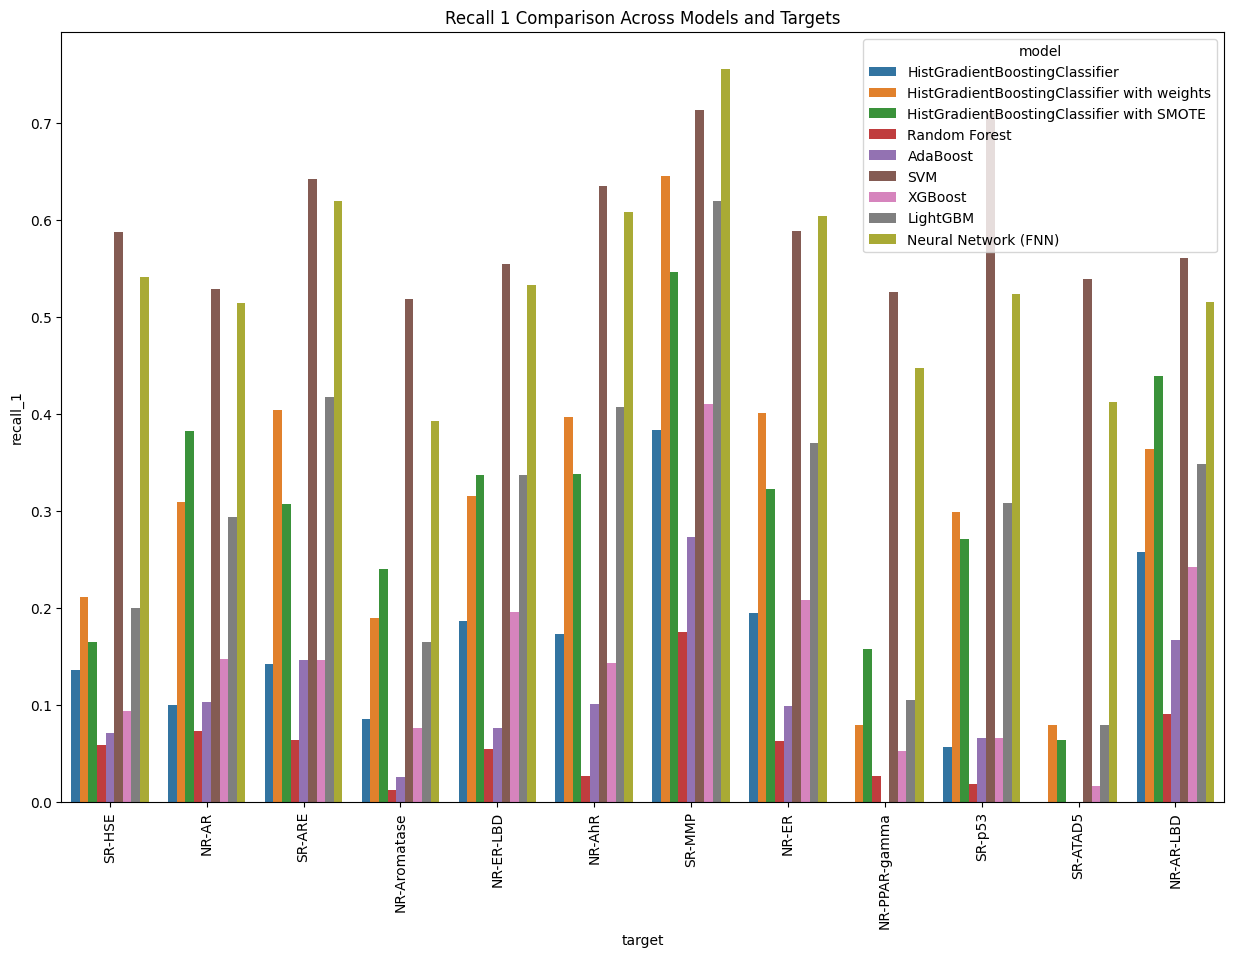

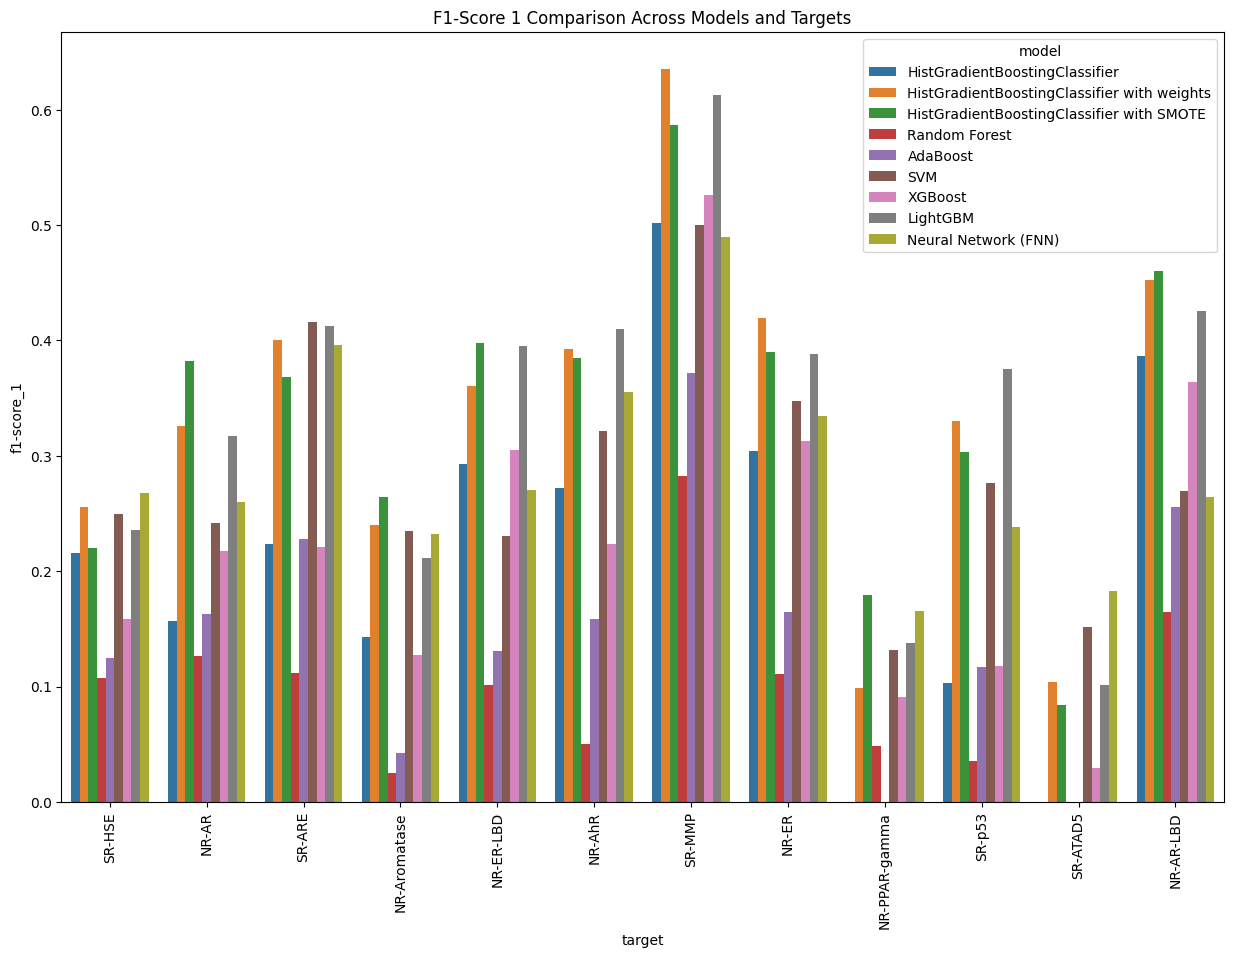

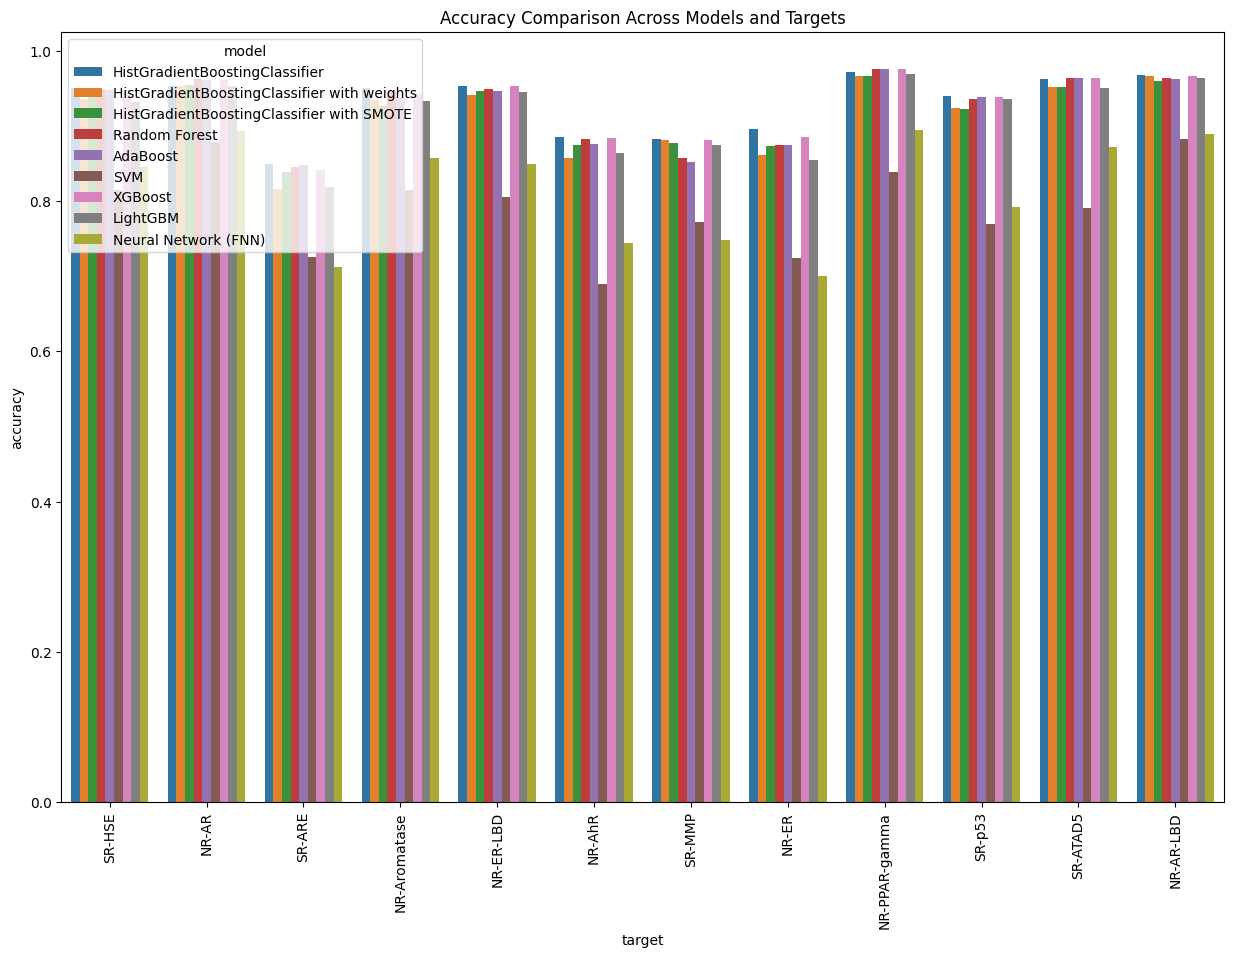

In [ ]:
model_names = ['HistGradientBoostingClassifier', 'HistGradientBoostingClassifier with weights', 'HistGradientBoostingClassifier with SMOTE', 'Random Forest', 'AdaBoost', 'SVM', 'XGBoost', 'LightGBM', 'Neural Network (FNN)']

for i, df_m in enumerate(df_list, start=1):
    df_m['model'] = model_names[i-1]

df_all_metrics = pd.concat(df_list).reset_index().rename(columns={'index': 'target'})

metrics_to_plot = ['precision_0', 'recall_0', 'f1-score_0', 'precision_1', 'recall_1', 'f1-score_1', 'accuracy']

# Loop through each metric and create a plot
for metric in metrics_to_plot:
    plt.figure(figsize=(15, 10))
    sns.barplot(data=df_all_metrics, x='target', y=metric, hue='model')
    plt.xticks(rotation=90)
    plt.title(f'{metric.replace("_", " ").title()} Comparison Across Models and Targets')
    plt.show()


*Compare based on average F-1 score of class 1 (fewer represented)*

In [ ]:
df_list_cleaned = [df_m.drop(columns='model') for df_m in df_list]

# Calculating average metrics for each model
average_metrics = []
for i, df_m in enumerate(df_list_cleaned):
    avg_metrics = df_m.mean().to_dict()
    avg_metrics['model'] = model_names[i-1]
    average_metrics.append(avg_metrics)

# Creating DataFrame for average metrics
df_avg_metrics = pd.DataFrame(average_metrics)

# Ranking models based on f1-score for class 1 and overall accuracy
df_avg_metrics['rank_f1_1'] = df_avg_metrics['f1-score_1'].rank(ascending=False)
df_avg_metrics['rank_accuracy'] = df_avg_metrics['accuracy'].rank(ascending=False)

# Calculating an overall rank (average of the two ranks)
df_avg_metrics['overall_rank'] = df_avg_metrics[['rank_f1_1', 'rank_accuracy']].mean(axis=1)

# Sorting by overall rank
df_avg_metrics = df_avg_metrics.sort_values('overall_rank')

# Displaying the model names along with their ranks
df_avg_metrics_with_names = df_avg_metrics[['model', 'f1-score_1', 'accuracy', 'overall_rank']].copy()
df_avg_metrics_with_names.columns = ['Model', 'F1-Score (Class 1)', 'Accuracy', 'Overall Rank']
df_avg_metrics_with_names

,Model,F1-Score (Class 1),Accuracy,Overall Rank
2,HistGradientBoostingClassifier with weights,0.335088,0.919465,3.5
7,XGBoost,0.335257,0.916498,3.5
0,Neural Network (FNN),0.216694,0.930534,4.0
6,SVM,0.224376,0.928809,4.0
1,HistGradientBoostingClassifier,0.334540,0.915918,5.0
3,HistGradientBoostingClassifier with SMOTE,0.096974,0.925763,6.0
4,Random Forest,0.146363,0.924025,6.0
8,LightGBM,0.288064,0.816656,6.0
5,AdaBoost,0.280908,0.792365,7.0


*Compare based on average F-1 score of class 0*

In [ ]:
average_metrics = []
for i, df_m in enumerate(df_list_cleaned):
    avg_metrics = df_m.mean().to_dict()
    avg_metrics['model'] = model_names[i-1]
    average_metrics.append(avg_metrics)

df_avg_metrics = pd.DataFrame(average_metrics)

df_avg_metrics['rank_f1_0'] = df_avg_metrics['f1-score_0'].rank(ascending=False)
df_avg_metrics['rank_accuracy'] = df_avg_metrics['accuracy'].rank(ascending=False)

df_avg_metrics['overall_rank'] = df_avg_metrics[['rank_f1_0', 'rank_accuracy']].mean(axis=1)

df_avg_metrics = df_avg_metrics.sort_values('overall_rank')

df_avg_metrics_with_names = df_avg_metrics[['model', 'f1-score_0', 'accuracy', 'overall_rank']].copy()
df_avg_metrics_with_names.columns = ['Model', 'F1-Score (Class 0)', 'Accuracy', 'Overall Rank']
df_avg_metrics_with_names

,Model,F1-Score (Class 0),Accuracy,Overall Rank
0,Neural Network (FNN),0.962779,0.930534,1.0
6,SVM,0.961718,0.928809,2.0
3,HistGradientBoostingClassifier with SMOTE,0.960514,0.925763,3.0
4,Random Forest,0.959241,0.924025,4.0
2,HistGradientBoostingClassifier with weights,0.955887,0.919465,5.0
7,XGBoost,0.953615,0.916498,6.0
1,HistGradientBoostingClassifier,0.953298,0.915918,7.0
8,LightGBM,0.889951,0.816656,8.0
5,AdaBoost,0.875041,0.792365,9.0


The dataset exhibits class imbalance, particularly in class 1, which poses challenges for model performance. Decision tree-based algorithms (Random Forest, AdaBoost, XGBoost, LightGBM, HistGradientBoostingClassifier) demonstrate better precision, while SVM and Neural Networks perform better on recall. However, none of the models effectively handle the class imbalance issue in toxicity prediction.
During the early stages of drug design, when screening large numbers of compounds for potential toxicity, precision may be more important. High precision ensures that the compounds selected for further development are less likely to have unforeseen toxic effects, reducing the risk of wasting resources on toxic compounds.
In preclinical studies, where the goal is to assess the safety of a drug candidate before human trials, a balance between precision and recall is often necessary. While it's important to identify potentially toxic compounds (high recall), false positives can be costly in terms of resources and time spent on further evaluation (high precision).